In [1]:
# interpolate some variables: 
# averaging kernel, pressure weighting function, xco2_priori
# from OCO2 20 levels to GEOS-Chem 47 levels

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re

In [ ]:
month = 2 # 1,2,3, = Jan, Feb, Mar, 2018

In [3]:
# Name of input Netcdf file
satellite_directory = '/geos/u73/msadiq/satellite/oco-2/'
satellite_file = '2d_OCO2_extract_20180' + str(month) + '.nc'

model_file = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018-0' + str(month) + '/nd51/2d_ts_satellite.20180' + str(month) + '.nc'

output_file = satellite_directory + 'interpolated_' + satellite_file

In [4]:
ds_satellite = xr.open_dataset(satellite_directory + satellite_file)
needed_vars = ['xco2_averaging_kernel', 
               'co2_profile_apriori',
               'pressure_weight']

In [5]:
ds_model = xr.open_dataset(model_file)

In [6]:
record = ds_model['record'].values
record

array([     0,      1,      2, ..., 366909, 366910, 366911])

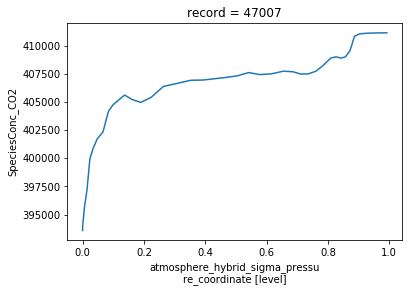

In [7]:
ds_model['SpeciesConc_CO2'][47007,:].plot()

In [8]:
# interpolate variables from 20 sigma levels to 47 levels
sigma_47 = ds_model.coords['levels'].values
sigma_20 = ds_satellite.coords['levels'].values
#pressure_47 = ds_model['PEDGE_S_PSURF']
#pressure_20 = ds_satellite['pressure']
sigma_47_flip = np.flip(sigma_47)
sigma_20

array([9.9999997e-05, 5.2631579e-02, 1.0526316e-01, 1.5789473e-01,
       2.1052632e-01, 2.6315790e-01, 3.1578946e-01, 3.6842105e-01,
       4.2105263e-01, 4.7368422e-01, 5.2631581e-01, 5.7894737e-01,
       6.3157892e-01, 6.8421054e-01, 7.3684210e-01, 7.8947371e-01,
       8.4210527e-01, 8.9473683e-01, 9.4736844e-01, 1.0000000e+00],
      dtype=float32)

In [9]:
# new dataset to data interpolated from OCO2 to 47 levels
interpolated = ds_model['SpeciesConc_CO2'].to_dataset()
interpolated['co2_profile_apriori'] = 0
interpolated

<xarray.Dataset>
Dimensions:              (levels: 47, record: 366912)
Coordinates:
  * record               (record) int64 0 1 2 3 ... 366908 366909 366910 366911
  * levels               (levels) float64 0.9925 0.9775 ... 0.000127 2.763e-05
Data variables:
    SpeciesConc_CO2      (record, levels) float32 ...
    co2_profile_apriori  int64 0

In [10]:
needed_vars

['xco2_averaging_kernel', 'co2_profile_apriori', 'pressure_weight']

In [11]:
# temporary 2d dataarray to save interpolated data
tmp = xr.DataArray(data = 0,
                   dims=('record', 'levels'),
                   coords=[record, ds_model.coords['levels']])
tmp = tmp.astype(dtype = 'float32')
tmp

<xarray.DataArray (record: 366912, levels: 47)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 366907 366908 366909 366910 366911
  * levels   (levels) float64 0.9925 0.9775 0.9624 ... 0.000127 2.763e-05

In [12]:
# interpolation
for ivar in needed_vars:
    before = ds_satellite[ivar].copy()
    for irecord in record:
        yp = before[irecord,:].values
        tmp[irecord,:] = np.interp(x=sigma_47, xp=sigma_20, fp=yp) # linear interpolation
    interpolated[ivar] = tmp.copy()
    print(ivar + ' done!')

xco2_averaging_kernel done!
co2_profile_apriori done!
pressure_weight done!


In [13]:
# normalise pressure weighting function for each record, needs to add up to one
pres_wgt = interpolated['pressure_weight']
for irecord in record:
    norm = pres_wgt[irecord,:].sum()
    pres_wgt[irecord,:] = pres_wgt[irecord,:] / norm
interpolated['pressure_weight'] = pres_wgt.copy()

In [14]:
# variables need not to be interpolated
noneed_interp = ['xco2', 'psurf', 'xco2_uncertainty', 'operation_mode']

In [15]:
for ivar in noneed_interp:
    interpolated[ivar] = ds_satellite[ivar].copy()

In [16]:
#interpolated['xco2_averaging_kernel'][47007,:].plot()
#interpolated['co2_profile_apriori'][47007,:].plot()
#interpolated['pressure_weight'][47007,:].plot()
#print(interpolated['pressure_weight'][47007,:].sum())

interpolated.attrs['comment'] = 'interpolated from 20-level OCO2'
interpolated.to_netcdf(output_file)

In [17]:
interpolated

<xarray.Dataset>
Dimensions:                (levels: 47, record: 366912)
Coordinates:
  * record                 (record) int64 0 1 2 3 ... 366909 366910 366911
  * levels                 (levels) float64 0.9925 0.9775 ... 0.000127 2.763e-05
Data variables:
    SpeciesConc_CO2        (record, levels) float32 ...
    co2_profile_apriori    (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    xco2_averaging_kernel  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    pressure_weight        (record, levels) float32 nan nan nan ... nan nan nan
    xco2                   (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    psurf                  (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    xco2_uncertainty       (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    operation_mode         (record) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    comment:  interpolated from 20-level OCO2